C:\Users\mursal\AppData\Local\Temp\ipykernel_17220\3607029227.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AMZN', start='1997-05-15', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\mursal\anaconda3\t\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
67/67 - 8s - 120ms/step - loss: 24.8364 - val_loss: 24.6946
Epoch 2/100
67/67 - 4s - 53ms/step - loss: 24.5042 - val_loss: 24.3551
Epoch 3/100
67/67 - 3s - 48ms/step - loss: 24.1754 - val_loss: 24.0214
Epoch 4/100
67/67 - 3s - 44ms/step - loss: 23.8500 - val_loss: 23.6925
Epoch 5/100
67/67 - 3s - 46ms/step - loss: 23.5277 - val_loss: 23.3677
Epoch 6/100
67/67 - 3s - 51ms/step - loss: 23.2087 - val_loss: 23.0490
Epoch 7/100
67/67 - 3s - 51ms/step - loss: 22.8928 - val_loss: 22.7345
Epoch 8/100
67/67 - 3s - 45ms/step - loss: 22.5800 - val_loss: 22.4230
Epoch 9/100
67/67 - 3s - 43ms/step - loss: 22.2704 - val_loss: 22.1147
Epoch 10/100
67/67 - 3s - 46ms/step - loss: 21.9637 - val_loss: 21.8094
Epoch 11/100
67/67 - 3s - 51ms/step - loss: 21.6600 - val_loss: 21.5071
Epoch 12/100
67/67 - 3s - 51ms/step - loss: 21.3593 - val_loss: 21.2080
Epoch 13/100
67/67 - 3s - 45ms/step - loss: 21.0615 - val_loss: 20.9114
Epoch 14/100
67/67 - 3s - 43ms/step - loss: 20.7666 - val_loss: 20.6181


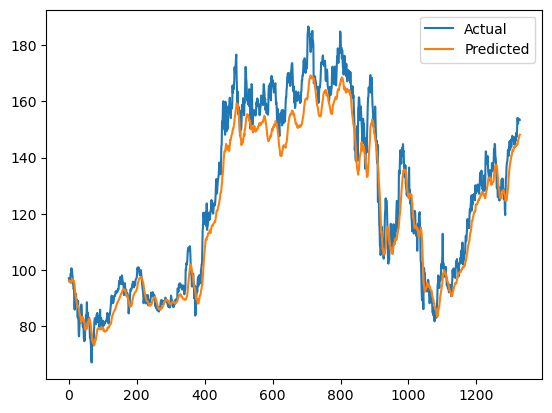

Predictions vs Actual
       Predicted      Actual
0      96.309036   97.052498
1      95.952858   96.320999
2      95.988235   97.214996
3      96.182610   95.750504
4      95.634308   96.718002
...          ...         ...
1324  146.596085  153.839996
1325  146.917740  153.419998
1326  147.234406  153.410004
1327  147.891296  153.339996
1328  148.124832  153.380005

[1329 rows x 2 columns]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Unseen Prediction: 149.27754
Epoch 1/100
67/67 - 4s - 53ms/step - loss: 3.9156 - val_loss: 3.8608
Epoch 2/100
67/67 - 4s - 52ms/step - loss: 3.8084 - val_loss: 3.7545
Epoch 3/100
67/67 - 3s - 52ms/step - loss: 3.7029 - val_loss: 3.6499
Epoch 4/100
67/67 - 3s - 47ms/step - loss: 3.5992 - val_loss: 3.5471
Epoch 5/100
67/67 - 3s - 44ms/step - loss: 3.4972 - val_loss: 3.4460
Epoch 6/100
67/67 - 3s - 48ms/step - loss: 3.3969 - val_loss: 3.3466
Epoch 7/100
67/67 - 3s - 51ms/step - loss: 3.2984 - val_loss: 3.2489
Epoch 8/100
67/67 - 4s - 53ms/step - loss: 3.2016 - val

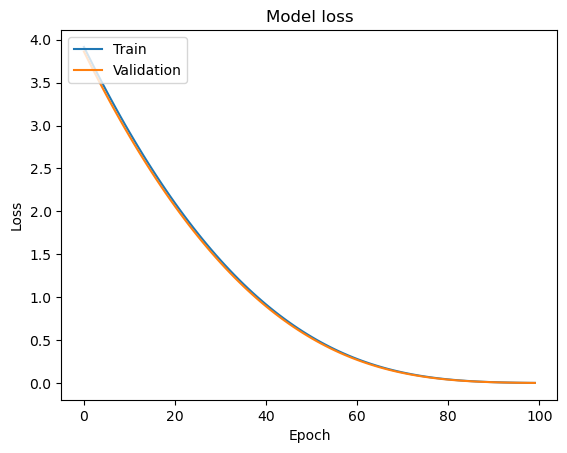

The model is not overfitting


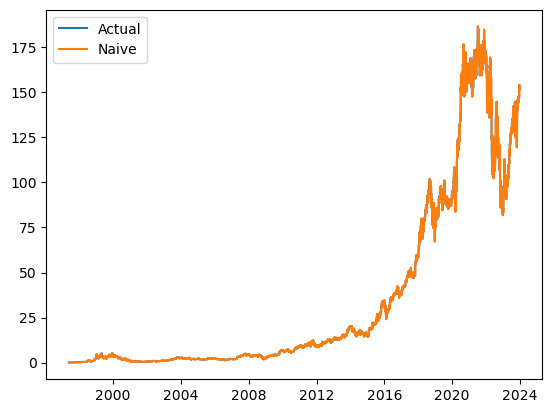

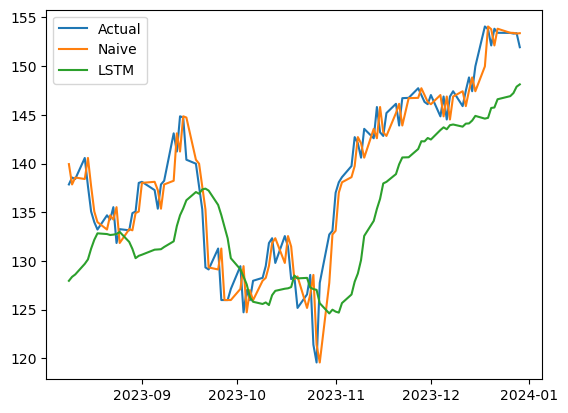

In [6]:


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta 


# Download Amazon's stock data from its IPO date till now
data = yf.download('AMZN', start='1997-05-15', end='2024-01-01')

# Add new features
data['Open-Close'] = data['Open'] - data['Close']
data['High-Low'] = data['High'] - data['Low']
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month
data['Year'] = data.index.year
data['Volume Change'] = data['Volume'].diff()
data['Price Change'] = data['Close'].diff()
data['5-day MA'] = data['Close'].rolling(window=5).mean()

# Drop missing values
data = data.dropna()

# Keep only the 'Close' and the new features
data = data[['Close', 'Open-Close', 'High-Low', 'Day', 'Month', 'Year', 'Volume Change', 'Price Change', '5-day MA']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Create a separate scaler for 'Close' prices
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(data[['Close']])

# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled.iloc[0:train_size, :], data_scaled.iloc[train_size:len(data_scaled), :]

# Function to create a dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1:]  # Use only the features for input
        X.append(a.values)
        Y.append(dataset.iloc[i + look_back, 0])  # Use 'Close' for output
    return np.array(X), np.array(Y)

# Create datasets for training and testing
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001)

model = Sequential()
model.add(LSTM(250, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), bias_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.2))
model.add(LSTM(250, bias_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=2, validation_split=0.2, callbacks=[early_stopping])

# Predict the stock prices on the testing data
predictions = model.predict(X_test)
predictions = close_scaler.inverse_transform(predictions)  # Use the 'close_scaler' here

# Compare the predicted prices with the actual values
Y_test = close_scaler.inverse_transform([Y_test])  # Use the 'close_scaler' here
plt.plot(Y_test[0])
plt.plot(predictions[:, 0])
plt.legend(['Actual', 'Predicted'])
plt.show()

# Print Predictions vs Actual
print('Predictions vs Actual')
print(pd.DataFrame({'Predicted': predictions[:, 0], 'Actual': Y_test[0]}))

# Test on unseen data
unseen_data = data_scaled.iloc[-look_back:, 1:]  # Use only the features for input
unseen_data = np.reshape(unseen_data.values, (1, unseen_data.shape[0], unseen_data.shape[1]))
unseen_prediction = model.predict(unseen_data)
unseen_prediction = close_scaler.inverse_transform(unseen_prediction)  # Use the 'close_scaler' here
print('Unseen Prediction:', unseen_prediction[0][0])

# Plot train loss vs validation loss
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=2, validation_split=0.2, callbacks=[early_stopping])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print overfitting or not
if history.history['val_loss'][-1] < history.history['loss'][-1]:
    print('The model is not overfitting')
else:
    print('The model is overfitting')

# Create a Niave forecast
data['Naive'] = data['Close'].shift(1)
data = data.dropna()

# Plot the naive forecast
plt.plot(data['Close'], label='Actual')
plt.plot(data['Naive'], label='Naive')
plt.legend()
plt.show()

# Compare Niave forecast with LSTM forecast
plt.plot(data['Close'][-100:], label='Actual')
plt.plot(data['Naive'][-100:], label='Naive')
plt.plot(data['Close'][-100:].index, predictions[-100:], label='LSTM')
plt.legend()
plt.show()